In [1]:
import torch
if torch.cuda.is_available():
    device = torch.device("cuda")  # you can continue going on here, like cuda:1 cuda:2....etc. 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")
# torch.cuda.device_count()

Running on the GPU


In [2]:
import pandas as pd
import numpy as np

data = pd.read_csv('kuairand_sequence.csv',index_col=0)
# data['user_id'].value_counts()

In [3]:
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import random
from torch.utils.data import Dataset, DataLoader,TensorDataset

max_length = 100
num_user = len(data['user_id'].unique())
state_feature = len(data.columns) - 1
action_feature = 3

uid = data['user_id'].unique()
uid
print(state_feature)

27


In [4]:
State = np.zeros(((num_user,max_length,state_feature)))
Action = np.zeros((num_user,max_length,action_feature))
# print(Action)
# conversion = np.array(conversion_one_hot)

j = 0
for i in uid:
    state_sequence = np.array(data[data['user_id']==i])[:-1]
    # state_sequence = np.array(data[data['user_id']==i].drop(['short','mid','long'],axis=1))
    action_sequence = np.array(data[data['user_id']==i][['short','mid','long']])[1:]
    # action_sequence = np.array(data[data['user_id']==i][['short','mid','long']])
    # print(action_sequence)
    state = np.pad(state_sequence,((0,max_length-len(state_sequence)),(0,0)))[:,1:]
    action = np.pad(action_sequence,((0,max_length-len(action_sequence)),(0,0)))
    State[j] = state
    Action[j] = action
    j += 1
print(len(State))
print(len(Action))

6269
6269


In [39]:
# print(len(con_X))
# print(len(non_X))
length = 1
max_number_traj = 80000
# number_traj = 10000
number_traj = 0
def Select_trajectory(X,Y,number_traj):
    Select_states = []
    Select_actions = []
    # for s in range(number_traj):
    while True:
        i = random.randint(0,len(X)-1)
        select_state = X[i]
        select_action = Y[i]
        # print(select_state)
        # print(select_action)
        for k in range(0,max_length):
            # print(select_episode[k])
            if select_state[k].any() == 0:
                max_episode_length = k
                break
        # print(k)
        # print(max_episode_length)
        if max_episode_length >= length + 1:
            j = random.randint(0,max_episode_length-length-1)
            select_state = select_state[j:j+length]
            select_action = select_action[j:j+length]
            Select_states.append(select_state)
            Select_actions.append(select_action)
            number_traj += 1
        # print(select_trajectory)
        if number_traj == max_number_traj:
            break
    return np.array(Select_states),np.array(Select_actions)

X , Y = Select_trajectory(State,Action,number_traj)
print(len(X))
# Y = np.concatenate((con_Y , non_Y),axis=0)
print(len(Y))

80000
80000


In [40]:
np.random.seed(2023)
per = np.random.permutation(X.shape[0])
# print(per)
X = X[per]
Y = Y[per]
# print(sum(Y))

In [41]:
np.array([0.5,0,0]).any()

True

In [42]:
def split_data(X,Y,timestep, input_size, output_size):
    # dataX = []
    # dataY = []

    # for traj_index in range(number_traj):
    #     X = []
    #     Y = []
    #     for index in range(length):
    #     # dataX.append(data[index: index + timestep][:, 0])
    #     # dataY.append(data[index + timestep][0])
    #         X.append(data[traj_index][6 * index : 6 * index + 6])
    #         Y.append(data[traj_index][6 * index + 6])
    #     dataX.append(X)
    #     dataY.append(Y)
    # dataX = np.array(dataX)
    # dataY = np.array(dataY)

    train_size = int(np.round(0.8 * X.shape[0]))
    print(train_size)

    # x_train = dataX[: train_size, :].reshape(-1, timestep,input_size)
    # y_train = dataY[: train_size].reshape(-1,timestep, 1)
    
    # x_test = dataX[train_size:, :].reshape(-1,timestep, input_size)
    # y_test = dataY[train_size:].reshape(-1,timestep, 1)

    x_train = X[: train_size, :].reshape(-1, timestep,input_size)
    y_train = Y[: train_size].reshape(-1,timestep, output_size) 

    x_test = X[train_size:, :].reshape(-1, timestep,input_size)
    y_test = Y[train_size:].reshape(-1,timestep, output_size)

    return [x_train, y_train, x_test, y_test]
X1,Y1,X2,Y2=split_data(X,Y,length,state_feature,action_feature)

# print(len(X2))
# print(len(X2))
X1,Y1=torch.from_numpy(X1).to(torch.float32).to(device),torch.from_numpy(Y1).to(torch.float32).to(device)
# print(Y2)
X2,Y2=torch.from_numpy(X2).to(torch.float32).to(device),torch.from_numpy(Y2).to(torch.float32).to(device)
# X,Y=torch.from_numpy(X).to(torch.float32),torch.from_numpy(Y).to(torch.float32)
train_ids = TensorDataset(X1,Y1)
test_ids = TensorDataset(X2,Y2)
# data_ids = TensorDataset(X,Y)
# print(train_ids[12])
print(test_ids[0])

64000
(tensor([[0.6522, 0.5555, 0.0000, 0.0000, 0.0020, 0.0000, 1.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 1.0000,
         0.3333, 0.2041, 0.1367, 0.0000, 0.0000, 0.2564, 0.3311, 0.1667, 1.0000]],
       device='cuda:0'), tensor([[1., 0., 0.]], device='cuda:0'))


In [43]:
print(X1.shape)

torch.Size([64000, 1, 27])


In [46]:
class MLP(torch.nn.Module):
    def __init__(self, feature_size, hidden_size, output_size):
        # super().__init__(state_dim, act_dim, max_length=max_length)
        super(MLP,self).__init__()
        self.softmax = nn.Softmax(dim=-1)
        self.sigmoid = nn.Sigmoid()
        self.fc1 = nn.Linear(feature_size, hidden_size)
        self.hidden = nn.Linear(hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        self.LeakyReLU = nn.LeakyReLU()
        self.dropout = nn.Dropout(p=0.2)
    def forward(self, x):
        x = self.fc1(x)
        # x = self.dropout(x)
        x = self.LeakyReLU(x)     
        x = self.hidden(x)
        x = self.LeakyReLU(x)
        x = self.hidden(x)
        # x = self.dropout(x)
        x = self.LeakyReLU(x)
        x = self.fc2(x)           
        # x = self.softmax(x)
        x = F.softmax(x,dim=2)
        return x

In [47]:
X = torch.rand(1,5,3).to(device)
Net = MLP(3,5,3).to(device)
Net
print(Net(X))

tensor([[[0.2516, 0.3610, 0.3874],
         [0.2516, 0.3611, 0.3873],
         [0.2516, 0.3613, 0.3871],
         [0.2516, 0.3610, 0.3874],
         [0.2516, 0.3609, 0.3875]]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


In [48]:
Batchsize = 512
# data_train_loader = DataLoader(dataset=train_ids, batch_size=Batchsize, shuffle=True)
data_train_loader = DataLoader(dataset=train_ids, batch_size=Batchsize, shuffle=False)
data_test_loader = DataLoader(dataset=test_ids, batch_size=1, shuffle=False,drop_last=False)
# data_full_loader = DataLoader(dataset=data_ids, batch_size=1, shuffle=True)


Loss of episode 0 = 0.22403915
Loss of episode 1 = 0.22390714
Loss of episode 2 = 0.2237481
Loss of episode 3 = 0.22345045
Loss of episode 4 = 0.22297457
Loss of episode 5 = 0.22227372
Loss of episode 6 = 0.22125554
Loss of episode 7 = 0.2198283
Loss of episode 8 = 0.21793224
Loss of episode 9 = 0.21555623
Loss of episode 10 = 0.21247943
Loss of episode 11 = 0.20884413
Loss of episode 12 = 0.20497023
Loss of episode 13 = 0.20065372
Loss of episode 14 = 0.19648279
Loss of episode 15 = 0.19219653
Loss of episode 16 = 0.18812454
Loss of episode 17 = 0.18423101
Loss of episode 18 = 0.18044879
Loss of episode 19 = 0.17728887
Loss of episode 20 = 0.17437503
Loss of episode 21 = 0.17182884
Loss of episode 22 = 0.16953452
Loss of episode 23 = 0.16665435
Loss of episode 24 = 0.16435014
Loss of episode 25 = 0.16189373
Loss of episode 26 = 0.15963036
Loss of episode 27 = 0.15748814
Loss of episode 28 = 0.15532894
Loss of episode 29 = 0.15270907
Loss of episode 30 = 0.15028265
Loss of episode 31 =

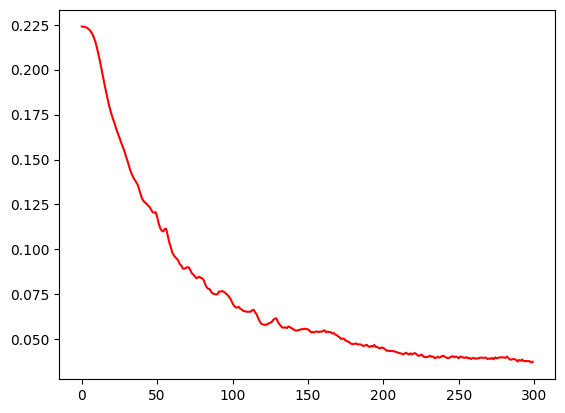

In [49]:
# feature_size, hidden_size, num_layers, output_size
# feature_size, hidden_size, output_size
Net = MLP(27,512,3).to(device)
num_epoch = 300
# optimizer = torch.optim.SGD(net.parameters(),lr=0.5)
optimizer = torch.optim.Adam(Net.parameters(),lr=0.001)
loss_func = torch.nn.MSELoss()
# loss_func = torch.nn.CrossEntropyLoss()
Loss=[]
for t in range(num_epoch):
    aver_loss = 0
    Net.train()
    for batch, data in enumerate(data_train_loader):
    # for x,y in data_train_loader:
        x, y = data
        # print(x.shape)
        prediction = Net(x)
        # prediction = torch.transpose(prediction, dim0=0, dim1=1)
        # print(y[0])
        # print(prediction[:,0,:].shape)
        # print(y[:,0,:].shape)
        loss = loss_func(prediction[:,0,:],y[:,0,:])
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        aver_loss += loss
    # print('Loss of episode %s ='%t,loss.cpu().data.numpy())
    aver_loss /= batch
    aver_loss=aver_loss.cpu().detach().numpy()
    print('Loss of episode %s ='%t,aver_loss)
    # print(t)
    Loss.append(aver_loss)
    # Loss.append(loss.detach().numpy())
plt.plot(Loss,color='r')
    # plt.show()
    # print(loss)
    # if t%5==0:
    #     plt.cla()
    #     plt.scatter(x.data.numpy(),y.data.numpy())
    #     plt.plot(x.data.numpy(),prediction.data.numpy(),'r-',lw=5)
    #     plt.text(0.5,0,'Loss=%.4f' % loss.data,fontdict={'size':20,'color':'red'})
    #     plt.pause(0.1)
# print(gru)

In [50]:
from torchsummary import summary
from torchvision.models import vgg16
device = torch.device("cuda")
# myNet = vgg16().to(device)  
# summary(myNet, (3, 64, 64)) 
Net_test = MLP(27,512,3).to(device)
# summary(gru_test, (8,11))
total = sum([param.nelement() for param in Net_test.parameters()])
print(total)
# gru_test

278531


## Training accuracy

In [51]:
Truth = []
Pred = []
aver_loss = 0
total_acc = 0
for batch, data in enumerate(data_train_loader):   
# for batch, data in enumerate(data_full_loader):
# for x,y in data_train_loader:
    x, y = data
    # print(x)
    # prediction =net(x)
    test = Net(x)
    # test = torch.transpose(test, dim0=0, dim1=1)
    # print(test)
    # print(y)
    # print(loss.data)
    # print(y[0])
    # print(test[0])
    a = torch.argmax(test,dim = 2).cpu().data.numpy().T[0]
    b = torch.argmax(y,dim = 2).cpu().data.numpy().T[0]
    # print(a.shape)
    # print(b.shape)
    # print(a)
    # print(sum(a==b))
    aver_acc = sum(a==b)
    # print(aver_acc)
    total_acc += aver_acc
    # print(total_acc)
    # print(aver_acc)
# print(batch)
print('acc =', total_acc/(0.8*max_number_traj))


acc = 0.87821875


## Inference accuracy

In [52]:

Loss=[]
Truth = []
Pred = []
aver_loss = 0
total_acc = 0
Net.eval()
for batch, data in enumerate(data_test_loader):   
    x, y = data
    # print(x)
    # prediction =net(x)
    Net.eval()
    test = Net(x)
    a = torch.argmax(test,dim = 2).cpu().data.numpy()[0]
    b = torch.argmax(y,dim = 2).cpu().data.numpy()[0]
    # print('-----------')
    # print('pred =',a[0])
    # print('true =',b[0])
    aver_acc = (a[0]==b[0])
    total_acc += aver_acc 

print('acc =', total_acc/(0.2*max_number_traj))



acc = 0.586375


## AUC

In [53]:
from sklearn.metrics import precision_score, roc_curve, auc
n_classes = 3
length = 1
# number_traj = 8000
aver_auc = np.zeros(n_classes)
total_precision = 0
Y_score = np.zeros(((length, int(0.2*max_number_traj), n_classes)))
# print(Y_score.shape)
Y_label = np.zeros(((length, int(0.2*max_number_traj), n_classes)))
for batch, data in enumerate(data_test_loader):   
    x, y = data
    # print(x)
    Net.eval()
    test = Net(x)
    y_score = test[0].cpu().data.numpy()
    y_label = y[0].cpu().data.numpy()
    # print(batch)
    for i in range(length):
        Y_score[i][batch] = y_score[i]
        Y_label[i][batch] = y_label[i]
fpr = dict()
tpr = dict()
roc_auc = dict()
aver_auc = np.zeros(n_classes)
for t in range(length):
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(Y_label[t][:, i], Y_score[t][:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        # aver_auc[i] += auc(fpr[i], tpr[i])
        aver_auc[i] += roc_auc[i]/length
    print('step %s AUC ='%(t+1),roc_auc) 
print('Average AUC =', aver_auc)

step 1 AUC = {0: 0.7279610915182508, 1: 0.7296717852286588, 2: 0.7197705326115019}
Average AUC = [0.72796109 0.72967179 0.71977053]


In [54]:
# aver_acc = np.zeros(length)
# for batch, data in enumerate(data_test_loader):   
# # for batch, data in enumerate(data_full_loader):
# # for x,y in data_train_loader:
#     x, y = data
#     # print(x)
#     # prediction =net(x)
#     test = gru(x)
#     # print(test)
#     # print(y)
#     a = torch.argmax(test,dim = 2).cpu().data.numpy()
#     b = torch.argmax(y,dim = 2).cpu().data.numpy()
#     # print('-----------')
#     # print('predict =',a.T[0])
#     # print('true =',b[0])
#     for i in range(length):
#         aver_acc[i] += a.T[0][i]==b[0][i]
# aver_acc /= batch
# print('step acc =', aver_acc)
# print('aver acc =', sum(aver_acc)/length)


In [55]:
from sklearn.metrics import f1_score, precision_score, recall_score



# print(y_pred)
# print(y_true)
for i in range(length):
    y_true = np.argmax(Y_label[i],axis = 1)
    y_pred = np.argmax(Y_score[i],axis = 1)
    f1 = round(f1_score(y_true, y_pred, average='macro' ),4)
    p = round(precision_score(y_true, y_pred, average='macro'),4)
    r = round(recall_score(y_true, y_pred, average='macro'),4)

    print('Step %s:'%(i+1),'F1 =', f1, 'Precision =', p, 'Recall =', r)


Step 1: F1 = 0.5862 Precision = 0.5863 Recall = 0.5862
